<a href="https://colab.research.google.com/github/SondipPoulSingh/Deep-Learning/blob/main/Pretrained_Model_and_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Pretrained models are models that already trained on a dataset (usually on a larger dataset). Using information learned by the pretrained models on our own model known as transfer learning. As example if someone knows how to drive a bicycle, he can use the knowledge to learn drive motor cycle. [Trend](https://machine-learning.paperspace.com/wiki/transfer-learning)<br><br>
some example of pretrained models are AlexNet, VGG16, GoogleNet, ResNet etc. Those models are pre trained
on ImageNet dataset. ImageNet dataset has 1.2 million images of 1000 classes. The original dataset was provided
by Fei Fei li in 2007 with 14 million images and 20,000 classes. Later a competition known as ILSVRC (Imagent 
Large Scale Visual Recognition Competition) started with 1.2 million images of 1000 classes. We can use those
models in our own model. Keras already included them.*

### Importing Dataset

In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

! kaggle datasets download -d salader/dogs-vs-cats
# command from the dataset API https://www.kaggle.com/datasets/salader/dogs-vs-cats

 99% 1.06G/1.06G [00:06<00:00, 189MB/s]
100% 1.06G/1.06G [00:06<00:00, 178MB/s]


In [2]:
from zipfile import ZipFile

with ZipFile('/content/dogs-vs-cats.zip','r') as zip:
  zip.extractall('/content')

### Testing a Pretrained Model

In [3]:
# Before starting with cat dog dataset let practice with simple data with pretrained models.

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications.resnet50 import ResNet50 
from tensorflow.keras.applications.resnet50 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image

In [5]:
model = ResNet50(weights='imagenet') 
# https://keras.io/api/applications/
# model.summary()

102967424/102967424 [==============================] - 1s 0us/step


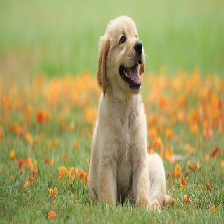

In [6]:
img = image.load_img('/content/dog.jpg', target_size=(224,224))
img

In [7]:
img = image.img_to_array(img)
img = img.reshape(1,224,224,3)
x = preprocess_input(img)

In [8]:
pred = model.predict(x)
decode_predictions(pred,top=3) # decode_predictions(pred,top=3)[0]

35363/35363 [==============================] - 0s 0us/step


[[('n02113799', 'standard_poodle', 0.80474484),
  ('n02093647', 'Bedlington_terrier', 0.12286486),
  ('n02088094', 'Afghan_hound', 0.03103821)]]

### Working on Larger Dataset

We can extract features by changing the dense layers and using only the convnet layers of any model. 
When we also changes the conv layers it is known as fine tuning. Fine tuning applied in cases when we 
have objects that is not seen by the pretrained model.

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

In [10]:
base_model = VGG16(
              weights='imagenet',
              include_top=False,
              input_shape=(200,200,3)
              )

58889256/58889256 [==============================] - 0s 0us/step


In [11]:
base_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 200, 200, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 200, 200, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 200, 200, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 100, 100, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 100, 100, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 100, 100, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 50, 50, 128)       0     

In [12]:
model = Sequential()
model.add(base_model)
base_model.trainable=False
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [13]:
model.summary() # summary shows that only the Dense layers are trainable

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense (Dense)               (None, 256)               4718848   
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
                                                                 
Total params: 19,433,793
Trainable params: 4,719,105
Non-trainable params: 14,714,688
_________________________________________________________________


In [14]:
train_datagen = tf.keras.utils.image_dataset_from_directory(
    '/content/train',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(200, 200),
    )

test_datagen = tf.keras.utils.image_dataset_from_directory(
    '/content/test',
    labels='inferred',
    label_mode='int',
    batch_size=32,
    image_size=(200, 200),
    )

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [15]:
# Normalizing the generator data
def normalize(image, label):
  data = tf.cast(image/255. ,tf.float32)
  return image,label

train_datagen_normalized = train_datagen.map(normalize)
test_datagen_normalized = test_datagen.map(normalize)

In [16]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']
              )

In [17]:
history = model.fit(train_datagen_normalized, epochs=5, validation_data=test_datagen_normalized)

Epoch 1/5
625/625 [==============================] - 117s 182ms/step - loss: 0.5071 - accuracy: 0.9546 - val_loss: 0.1301 - val_accuracy: 0.9580
Epoch 2/5
625/625 [==============================] - 113s 181ms/step - loss: 0.0423 - accuracy: 0.9845 - val_loss: 0.0944 - val_accuracy: 0.9650
Epoch 3/5
625/625 [==============================] - 114s 181ms/step - loss: 0.0216 - accuracy: 0.9912 - val_loss: 0.1026 - val_accuracy: 0.9670
Epoch 4/5
625/625 [==============================] - 113s 181ms/step - loss: 0.0129 - accuracy: 0.9948 - val_loss: 0.1296 - val_accuracy: 0.9620
Epoch 5/5
625/625 [==============================] - 114s 181ms/step - loss: 0.0225 - accuracy: 0.9923 - val_loss: 0.1509 - val_accuracy: 0.9592


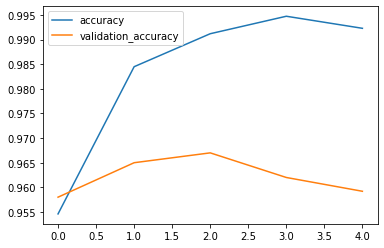

In [18]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='validation_accuracy')
plt.legend()
plt.show()